<a href="https://colab.research.google.com/github/sibby-killer/assg_energy_week2/blob/main/01_solar_potential_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import io, requests
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:
# Folders
BASE_DIR = Path(".")
DATA_DIR = BASE_DIR / "data"
ASSETS_DIR = BASE_DIR / "assets"
DATA_DIR.mkdir(exist_ok=True)
ASSETS_DIR.mkdir(exist_ok=True)

In [4]:
# NASA POWER URL builder
def power_url(lat, lon, start="20180101", end="20231231"):
    params = "ALLSKY_SFC_SW_DWN,T2M,RH2M,WS2M,PRECTOTCORR"
    return ("https://power.larc.nasa.gov/api/temporal/daily/point"
            f"?parameters={params}&start={start}&end={end}"
            f"&latitude={lat}&longitude={lon}&community=RE&format=CSV&header=true")

In [5]:

# Location (Nairobi by default). Change LAT, LON for your city if you want.
LAT, LON = -1.2921, 36.8219
csv_path = DATA_DIR / "nairobi_power_2018_2023.csv"

In [6]:

# Download data if not present
if not csv_path.exists():
    url = power_url(LAT, LON)
    print("Downloading:", url)
    r = requests.get(url, headers={"User-Agent": "Mozilla/5.0"}, timeout=60)
    r.raise_for_status()
    csv_path.write_text(r.text, encoding="utf-8")
    print("Saved to", csv_path)
else:
    print("Using local file:", csv_path)

Downloading: https://power.larc.nasa.gov/api/temporal/daily/point?parameters=ALLSKY_SFC_SW_DWN,T2M,RH2M,WS2M,PRECTOTCORR&start=20180101&end=20231231&latitude=-1.2921&longitude=36.8219&community=RE&format=CSV&header=true
Saved to data/nairobi_power_2018_2023.csv


In [7]:
# Robust reader (NASA adds header lines)
def read_power_csv(path: Path) -> pd.DataFrame:
    lines = path.read_text(encoding="utf-8").splitlines(True)
    header_idx = None
    for i, line in enumerate(lines):
        if line.strip().startswith("DATE,") or line.strip().startswith("YEAR,"):
            header_idx = i
            break
    if header_idx is None:
        for i, line in enumerate(lines):
            if "ALLSKY_SFC_SW_DWN" in line and "," in line:
                header_idx = max(i - 1, 0)
                break
    if header_idx is None:
        raise ValueError("Could not find header row in NASA POWER CSV.")
    df = pd.read_csv(io.StringIO("".join(lines[header_idx:])))
    if "DATE" in df.columns:
        df["date"] = pd.to_datetime(df["DATE"].astype(str), format="%Y%m%d")
    elif {"YEAR", "MO", "DY"}.issubset(df.columns):
        df["date"] = pd.to_datetime(dict(year=df["YEAR"], month=df["MO"], day=df["DY"]))
    else:
        raise ValueError("Unexpected date columns.")
    needed = ["ALLSKY_SFC_SW_DWN","T2M","RH2M","WS2M","PRECTOTCORR"]
    for c in needed:
        if c not in df.columns:
            raise ValueError(f"Missing required column: {c}")
    df = df[["date"] + needed].sort_values("date").reset_index(drop=True)
    df = df.replace([-99, -999, -9999], np.nan)
    return df

df = read_power_csv(csv_path)


Shape: (2191, 6)
Missing values:
 date                 0
ALLSKY_SFC_SW_DWN    0
T2M                  0
RH2M                 0
WS2M                 0
PRECTOTCORR          0
dtype: int64


,date,ALLSKY_SFC_SW_DWN,T2M,RH2M,WS2M,PRECTOTCORR
0,2018-01-01,5.9059,23.29,43.89,1.42,0.09
1,2018-01-02,5.7235,21.96,55.16,1.26,0.47
2,2018-01-03,4.7508,21.36,63.49,1.51,2.79
3,2018-01-04,2.6059,20.05,67.94,1.77,0.98
4,2018-01-05,5.3030,21.42,54.26,2.04,0.01


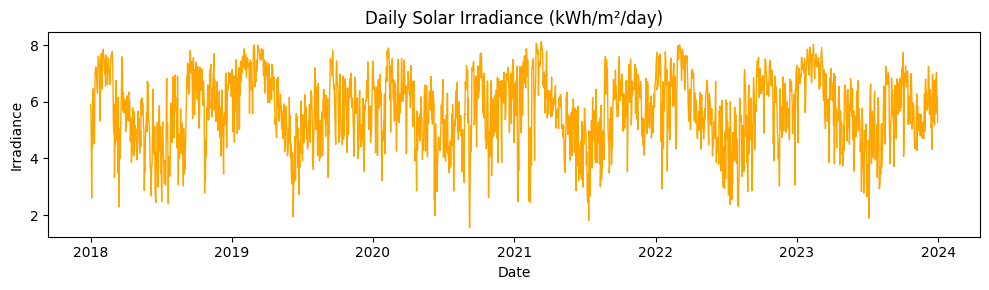

In [8]:
# Quick EDA
print("Shape:", df.shape)
print("Missing values:\n", df.isna().sum())
display(df.head())

plt.figure(figsize=(10,3))
plt.plot(df["date"], df["ALLSKY_SFC_SW_DWN"], color="orange", lw=1)
plt.title("Daily Solar Irradiance (kWh/m²/day)")
plt.xlabel("Date"); plt.ylabel("Irradiance")
plt.tight_layout(); plt.savefig(ASSETS_DIR / "eda_irradiance_timeseries.png", dpi=150)
plt.show()

In [9]:
# Feature engineering
df["doy"] = df["date"].dt.dayofyear
df["sin_doy"] = np.sin(2 * np.pi * df["doy"] / 365.25)
df["cos_doy"] = np.cos(2 * np.pi * df["doy"] / 365.25)
df["lag1"] = df["ALLSKY_SFC_SW_DWN"].shift(1)
df = df.dropna().reset_index(drop=True)

FEATURES = ["T2M","RH2M","WS2M","PRECTOTCORR","sin_doy","cos_doy","lag1"]
TARGET = "ALLSKY_SFC_SW_DWN"

In [10]:
# Time-based split (train: 2018–2022, test: 2023)
split_date = pd.Timestamp("2023-01-01")
train_mask = df["date"] < split_date
X_train, y_train = df.loc[train_mask, FEATURES], df.loc[train_mask, TARGET]
X_test,  y_test  = df.loc[~train_mask, FEATURES], df.loc[~train_mask, TARGET]
dates_test = df.loc[~train_mask, "date"]
print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (1825, 7) Test: (365, 7)


In [11]:
# Train models
baseline = Pipeline([("scaler", StandardScaler()), ("lr", LinearRegression())])
baseline.fit(X_train, y_train)
y_pred_lr = baseline.predict(X_test)

gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test)

In [14]:
# Evaluate (no 'squared' kwarg)
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score

def eval_metrics(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    mae = float(mean_absolute_error(y_true, y_pred))
    rmse = float(np.sqrt(np.mean((y_true - y_pred) ** 2)))  # RMSE via sqrt of MSE
    r2 = float(r2_score(y_true, y_pred))
    return {"MAE": mae, "RMSE": rmse, "R2": r2}

m_lr = eval_metrics(y_test, y_pred_lr)
m_gbr = eval_metrics(y_test, y_pred_gbr)
print("Linear:", {k: round(v,3) for k,v in m_lr.items()})
print("GBR   :", {k: round(v,3) for k,v in m_gbr.items()})

Linear: {'MAE': 0.568, 'RMSE': 0.72, 'R2': 0.632}
GBR   : {'MAE': 0.533, 'RMSE': 0.687, 'R2': 0.665}


In [15]:
# Save metrics
with open(ASSETS_DIR / "metrics.txt", "w") as f:
    for name, m in [("Linear", m_lr), ("GBR", m_gbr)]:
        f.write(f"{name}: MAE={m['MAE']:.3f}, RMSE={m['RMSE']:.3f}, R2={m['R2']:.3f}\n")

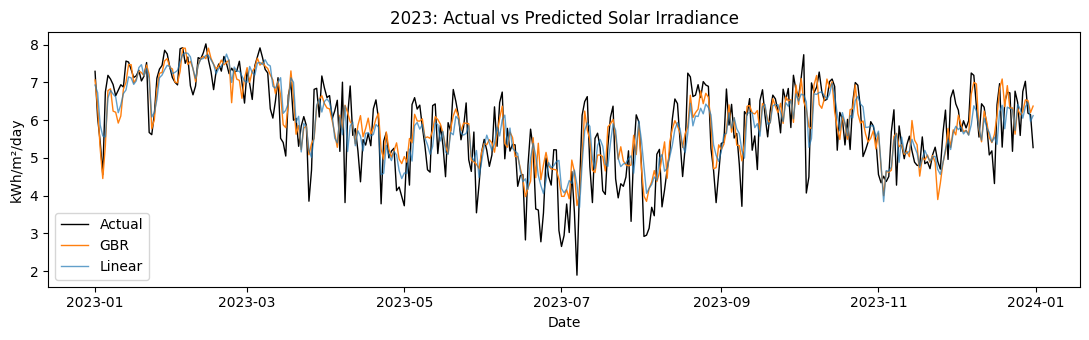

In [16]:
# Plots
# 1) Time series
plt.figure(figsize=(11,3.5))
plt.plot(dates_test, y_test.values, label="Actual", color="black", lw=1)
plt.plot(dates_test, y_pred_gbr, label="GBR", color="tab:orange", lw=1)
plt.plot(dates_test, y_pred_lr, label="Linear", color="tab:blue", alpha=0.7, lw=1)
plt.title("2023: Actual vs Predicted Solar Irradiance")
plt.xlabel("Date"); plt.ylabel("kWh/m²/day"); plt.legend()
plt.tight_layout(); plt.savefig(ASSETS_DIR / "timeseries_actual_vs_pred.png", dpi=150)
plt.show()


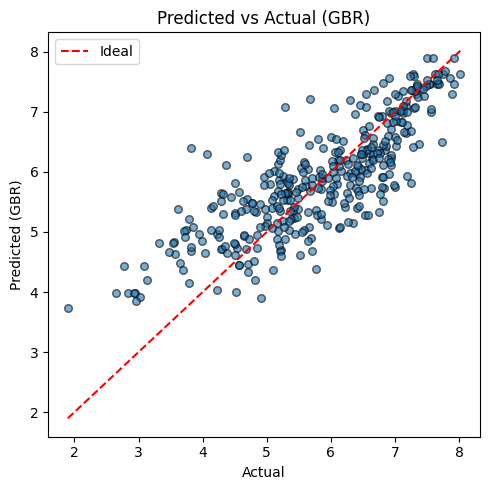

In [17]:
# 2) Scatter
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred_gbr, alpha=0.6, edgecolor="k", s=30)
mn, mx = float(min(y_test.min(), y_pred_gbr.min())), float(max(y_test.max(), y_pred_gbr.max()))
plt.plot([mn, mx], [mn, mx], "r--", label="Ideal")
plt.xlabel("Actual"); plt.ylabel("Predicted (GBR)"); plt.legend()
plt.title("Predicted vs Actual (GBR)")
plt.tight_layout(); plt.savefig(ASSETS_DIR / "scatter_pred_vs_actual_gbr.png", dpi=150)
plt.show()

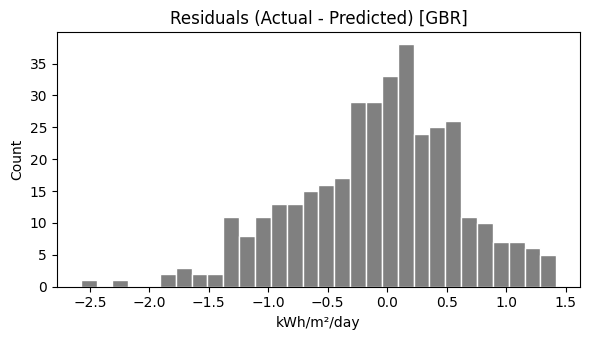

In [18]:
# 3) Residuals
residuals = y_test - y_pred_gbr
plt.figure(figsize=(6,3.5))
plt.hist(residuals, bins=30, color="gray", edgecolor="white")
plt.title("Residuals (Actual - Predicted) [GBR]")
plt.xlabel("kWh/m²/day"); plt.ylabel("Count")
plt.tight_layout(); plt.savefig(ASSETS_DIR / "residuals_hist_gbr.png", dpi=150)
plt.show()


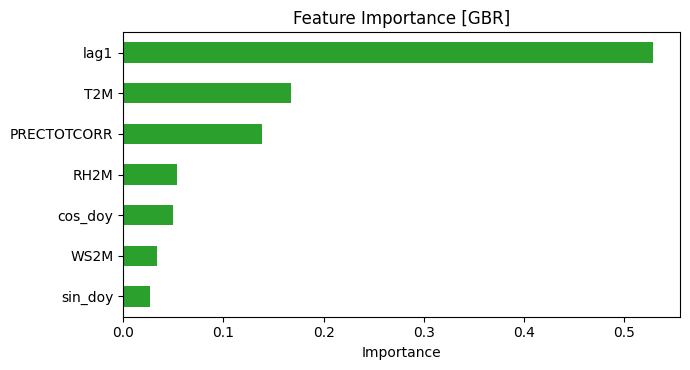

Saved images and metrics in: assets


In [19]:
# 4) Feature importance
importances = pd.Series(gbr.feature_importances_, index=FEATURES).sort_values()
plt.figure(figsize=(7,3.8))
importances.plot(kind="barh", color="tab:green")
plt.title("Feature Importance [GBR]")
plt.xlabel("Importance")
plt.tight_layout(); plt.savefig(ASSETS_DIR / "feature_importance_gbr.png", dpi=150)
plt.show()

print("Saved images and metrics in:", ASSETS_DIR)

In [20]:
# Create README.md with metrics auto-filled (if assets/metrics.txt exists)
from pathlib import Path
import re

ASSETS_DIR = Path("assets")
metrics_path = ASSETS_DIR / "metrics.txt"

lr = {"MAE": "TBD", "RMSE": "TBD", "R2": "TBD"}
gbr = {"MAE": "TBD", "RMSE": "TBD", "R2": "TBD"}

if metrics_path.exists():
    for line in metrics_path.read_text(encoding="utf-8").splitlines():
        line = line.strip()
        m = re.match(r'^(Linear|GBR)\s*:\s*MAE=([-\d\.]+),\s*RMSE=([-\d\.]+),\s*R2=([-\d\.]+)', line)
        if m:
            label, mae, rmse, r2 = m.groups()
            d = lr if label.startswith("Linear") else gbr
            d["MAE"], d["RMSE"], d["R2"] = mae, rmse, r2

readme = f"""# SDG 7: Predicting Daily Solar Energy Potential (NASA POWER, Supervised Regression) 🌞⚡

Forecast daily solar irradiance (kWh/m²/day) from weather variables to support renewable energy planning and grid operations. This project advances UN SDG 7: Affordable and Clean Energy by improving solar resource forecasting.

## Quick links
- Notebook: `notebooks/01_solar_potential_regression.ipynb`
- Script: `src/solar_regression.py`
- Assets (plots + metrics): `assets/`
- Open in Colab (update USERNAME/REPO after pushing):
  https://colab.research.google.com/github/USERNAME/REPO/blob/main/notebooks/01_solar_potential_regression.ipynb

## Overview
- Task: Supervised regression to predict `ALLSKY_SFC_SW_DWN` (daily solar irradiance).
- Why it matters: Better forecasts help size solar installations, plan storage, and manage grids—key to scaling clean energy.

## Results
- Gradient Boosting Regressor:
  - MAE: {gbr['MAE']} kWh/m²/day
  - RMSE: {gbr['RMSE']} kWh/m²/day
  - R²: {gbr['R2']}
- Linear Regression:
  - MAE: {lr['MAE']} kWh/m²/day
  - RMSE: {lr['RMSE']} kWh/m²/day
  - R²: {lr['R2']}

## Visuals
- EDA: Daily irradiance over time
  ![EDA Irradiance Timeseries](assets/eda_irradiance_timeseries.png)
- 2023 Actual vs Predicted (test set)
  ![Timeseries Actual vs Predicted](assets/timeseries_actual_vs_pred.png)
- Predicted vs Actual (GBR)
  ![Scatter Pred vs Actual (GBR)](assets/scatter_pred_vs_actual_gbr.png)
- Residuals (GBR)
  ![Residuals Histogram (GBR)](assets/residuals_hist_gbr.png)
- Feature Importance (GBR)
  ![Feature Importance (GBR)](assets/feature_importance_gbr.png)

## Dataset
- Source: NASA POWER Project (daily time series; public and free)
- Variables used:
  - Target: `ALLSKY_SFC_SW_DWN` (kWh/m²/day)
  - Features: `T2M` (°C), `RH2M` (%), `WS2M` (m/s), `PRECTOTCORR` (mm/day)
- Example API (Nairobi; 2018–2023):
  https://power.larc.nasa.gov/api/temporal/daily/point?parameters=ALLSKY_SFC_SW_DWN,T2M,RH2M,WS2M,PRECTOTCORR&start=20180101&end=20231231&latitude=-1.2921&longitude=36.8219&community=RE&format=CSV&header=true
- Note: The notebook downloads data automatically. Change LAT/LON to use a different city.

## Method
- Problem framing: Regression
- Split: Time-based
  - Train: 2018–2022
  - Test: 2023
- Features:
  - Raw: `T2M`, `RH2M`, `WS2M`, `PRECTOTCORR`
  - Engineered: `doy`, `sin_doy`, `cos_doy` (seasonality), `lag1` (previous day irradiance)
- Models:
  - Baseline: Linear Regression (with StandardScaler)
  - Main: GradientBoostingRegressor
- Metrics:
  - Primary: MAE
  - Secondary: RMSE, R²
- Visualizations: Timeseries (actual vs predicted), scatter (pred vs actual), residuals histogram, feature importances

## How to run

### Option A — Google Colab (recommended)
1) Open the notebook in Colab (link above).
2) Run all cells. It will:
   - Download NASA data
   - Train/evaluate models
   - Save plots and metrics to `assets/`
3) File → Save a copy in GitHub (commit the notebook).
4) Download `assets/*.png` + `assets/metrics.txt` from the Colab Files panel and upload them to your repo’s `assets/` folder.

### Option B — Local (Jupyter or Python)
- Setup:
  - Python 3.9+ recommended
  - `pip install -r requirements.txt`
- Run the notebook:
  - `jupyter notebook` → open `notebooks/01_solar_potential_regression.ipynb` → Run All
- Or run the script:
  - `python -c "from src.solar_regression import main; main(lat=-1.2921, lon=36.8219, out_stem='nairobi_power_2018_2023')"`

## Repo structure
- `notebooks/01_solar_potential_regression.ipynb`
- `src/solar_regression.py`
- `assets/`
  - `eda_irradiance_timeseries.png`
  - `timeseries_actual_vs_pred.png`
  - `scatter_pred_vs_actual_gbr.png`
  - `residuals_hist_gbr.png`
  - `feature_importance_gbr.png`
  - `metrics.txt`
- `requirements.txt`
- `README.md`

## Ethics & limitations
- Location-specific: A model trained for one site won’t generalize elsewhere without retraining.
- Data quality: NASA POWER blends satellite/model estimates; missing or biased periods are possible.
- Climate variability: Shifts or extremes can reduce accuracy; retrain periodically.
- Decision support only: Use results to inform planning, not real-time operational control without validation.

## SDG impact
Accurate solar forecasts help:
- Plan capacity and storage sizing
- Improve grid reliability
- Reduce fossil backup needs
This supports SDG 7: Affordable and Clean Energy.

## How to customize city
- In the notebook or `src/solar_regression.py`, change:
  - `LAT`, `LON` to your city’s coordinates
  - Optionally adjust `start`/`end` in `power_url`
- Re-run to regenerate data, metrics, and plots.

## Assignment deliverables mapping
- Code: `notebooks/01_solar_potential_regression.ipynb`, `src/solar_regression.py`
- README: This file, with embedded screenshots and instructions
- Screenshots/plots: `assets/*.png`
- Report/article: Problem → Data → Method → Results → Ethics → SDG Impact (link to this repo)
- Pitch deck: 8 slides (Title, Problem, Data, Approach, Results, Impact, Ethics, Next Steps)

## License & citation
- Code: MIT (adjust if preferred)
- Data: “Data courtesy of NASA/POWER Project at NASA Langley Research Center”
  NASA POWER API: https://power.larc.nasa.gov

## Requirements
- pandas
- numpy
- scikit-learn
- matplotlib
- requests
"""

Path("README.md").write_text(readme, encoding="utf-8")
print("README.md written. Open the Files panel to preview/download, or commit it via Colab: File → Save a copy in GitHub.")

README.md written. Open the Files panel to preview/download, or commit it via Colab: File → Save a copy in GitHub.
